In [1]:
import neptune as neptune
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import tempfile
import time

## Functions

In [2]:
def plot_loss_vs_lr(runs_table, ylim=None, title=None, figsize=(10, 6), ax=None, main_varibles=["job_config/common/dmodel"], ax_labels_font=12, tick_font=12, title_font=12, print_etas=False):
    """
    For each model width in the runs table, plots a line where the y-axis is the final loss value
    and the x-axis is the learning rate (lr). Uses different markers for finished vs running runs.

    Parameters:
    - runs_table (pd.DataFrame): The DataFrame returned by get_neptune_table(), containing run information.
    - ylim (tuple): Y-axis limits
    - title (str): Plot title
    - figsize (tuple): Figure size
    - ax (matplotlib axis): Axis to plot on
    - main_varibles (list[str]): Main variables column names
    - ax_labels_font (int): Font size for axis labels
    - tick_font (int): Font size for ticks
    - title_font (int): Font size for title

    Returns:
    - None
    """
    color_dict = {
        0: "#1f78b4",    # Blue
        1: "#33a02c",    # Green
        2: "#e31a1c",    # Red
        3: "#ff7f00",    # Orange
        4: "#6a3d9a",   # Purple
        5: "#a65628",     # Brown
        6: "#000000",   # Black
        
        # Main range - using ColorBrewer Set1 + extensions
        128: "#1f78b4",    # Blue
        256: "#33a02c",    # Green
        512: "#e31a1c",    # Red
        768: "#ff7f00",    # Orange
        1024: "#6a3d9a",   # Purple
        1536: "#a65628",     # Brown
        2048: "#000000",   # Black
    }

    # Ensure required columns are present in runs_table
    required_columns = ["sys/id", "learning_rate", "job_config/trainer/n_steps", "step"]
    required_columns.extend(main_varibles)
    for col in required_columns:
        if col not in runs_table.columns:
            raise ValueError(
                f"Column '{col}' is missing from runs_table. Please include it in the 'columns' parameter when calling get_neptune_table()."
            )

    # Check for required columns to determine completion status
    required_status_columns = ["job_config/trainer/n_steps", "step"]
    has_completion_info = all(col in runs_table.columns for col in required_status_columns)
    
    if not has_completion_info:
        raise ValueError(
            f"Columns 'job_config/trainer/n_steps' and 'step' are required to determine run completion status."
        )
    
    # Get final loss values for each run
    final_loss_df = get_final_loss_values(runs_table, main_varibles)

    # Remove entries with missing final loss
    final_loss_df = final_loss_df[final_loss_df["final_loss"].notnull()]
    
    # Add completion status based on comparing step with job_config/trainer/n_steps
    completion_map = {}
    for _, run_row in runs_table.iterrows():
        run_id = run_row["sys/id"]
        n_steps = run_row["job_config/trainer/n_steps"]
        current_step = run_row["step"]
        
        # Consider complete if current step equals or exceeds planned steps
        is_complete = current_step + 1 >= n_steps
        completion_map[run_id] = "complete" if is_complete else "running"
    
    final_loss_df["status"] = final_loss_df["run_id"].map(completion_map)

    final_loss_df.to_csv('final_loss_df.csv')

    grid_cols = [f'grid_val_{i}' for i in range(len(main_varibles))]

    grid_val_sets = (
        final_loss_df[grid_cols]
        .drop_duplicates()
        .sort_values(grid_cols)
        .itertuples(index=False, name=None)
    )

    var_labels_dict = {
        "job_config/common/dmodel": "dmodel:",
        "job_config/common/dff": "dff:",
        "job_config/common/expansion_rate": "Number of experts:",
        "job_config/common/granularity": "Granularity:",
        "job_config/model/encoder/block_fn/attention_fn/top_k": "top-k:",
        "job_config/common/kv_heads": "KV heads:",
        "job_config/common/sequence_length": "seq_len:",
    }

    for color_num, grid_vals in enumerate(grid_val_sets):
        mask = (final_loss_df[grid_cols] == grid_vals).all(axis=1)
        df_subset = final_loss_df[mask]

        # Separate finished and running runs
        finished_runs = df_subset[df_subset["status"] == "complete"]
        running_runs = df_subset[df_subset["status"] != "complete"]
        
        color = color_dict.get(color_num, None)

        # if type(model_width) is str:
        #     label_value = model_width.split('/')[-1]
        # else:
        #     label_value = model_width
        
        label = ""
        for name, value in zip(main_varibles, grid_vals):

            label += f"{var_labels_dict[name]} {value}, "
        label = label[:-1]
        
        # Plot finished runs with 'o' marker
        if not finished_runs.empty:
            finished_sorted = finished_runs.sort_values("lr")
            means_finished = finished_sorted.groupby("lr")["final_loss"].mean()
            lrs_finished = means_finished.index.to_numpy()
            losses_finished = means_finished.values
            
            if ax is None:
                plt.plot(lrs_finished, losses_finished, marker="o", color=color, 
                        label=label, linestyle='-')
            else:
                ax.plot(lrs_finished, losses_finished, marker="o", color=color,
                       label=label, linestyle='-')
        
        # Plot running runs with square marker
        if not running_runs.empty:
            running_sorted = running_runs.sort_values("lr")
            means_running = running_sorted.groupby("lr")["final_loss"].mean()
            lrs_running = means_running.index.to_numpy()
            losses_running = means_running.values
            
            if ax is None:
                plt.plot(lrs_running, losses_running, marker="s", color=color,
                        label=label, linestyle='--', markersize=6)
            else:
                ax.plot(lrs_running, losses_running, marker="s", color=color,
                       label=label, linestyle='--', markersize=6)
                
    if print_etas:

        now = pd.Timestamp.now()
        runs_table["sys/monitoring_time"] /= 3600
        runs_table['progress'] = runs_table["step"] / runs_table["job_config/trainer/n_steps"]

        # correct finished runs
        mask = runs_table["progress"] >= 1.0
        runs_table.loc[mask, "sys/monitoring_time"] = (
            runs_table.loc[mask, "sys/monitoring_time"] / runs_table.loc[mask, "progress"]
        )
        runs_table["progress"] = runs_table["progress"].clip(upper=1.0)

        runs_table['ETA'] = runs_table['sys/monitoring_time'] * ((1 / runs_table['progress']) - 1)
        runs_table['total'] = runs_table['ETA'] + runs_table['sys/monitoring_time']

        eta_cols = ["total", "ETA", "sys/monitoring_time", "progress"]


        print("ETAs")
        print(runs_table[eta_cols].to_string(float_format="{:.2f}".format))

        eta_cols.extend(main_varibles)
        runs_table[eta_cols].to_csv("etas.csv")


    if ax is None:
        plt.legend()
        plt.tick_params(axis='both', labelsize=tick_font)
        plt.xlabel("Learning Rate (lr)", fontsize=ax_labels_font)
        plt.ylabel("Final Loss Value", fontsize=ax_labels_font)
        if title is None:
            title = "Final Loss vs Learning Rate for Different Model Widths"
        plt.title(title, fontsize=title_font)
        plt.grid(True)
        plt.xscale("log")
        if ylim is not None:
            plt.ylim(ylim)
        plt.show()
    else:
        ax.legend()
        ax.set_xlabel("Learning Rate (lr)", fontsize=ax_labels_font)
        ax.set_ylabel("Final Loss Value", fontsize=ax_labels_font)
        ax.tick_params(axis='both', labelsize=tick_font)
        ax.set_xscale("log", base=2)
        if title is None:
            title = "Final Loss vs Learning Rate"
        ax.set_title(title, fontsize=title_font)
        ax.grid(True)
        if ylim is not None:
            ax.set_ylim(ylim)


def get_final_loss_values(runs_table, main_variables=["job_config/common/dmodel"]):
    """
    Fetches the final loss value for each run in the runs table.

    Parameters:
    - runs_table (pd.DataFrame): The DataFrame containing run information.

    Returns:
    - pd.DataFrame: A DataFrame with columns ['run_id', 'dmodel', 'lr', 'final_loss']
    """
    final_losses = []
    for _, run_row in runs_table.iterrows():
        run_id = run_row["sys/id"]
        lr = run_row["learning_rate"]
        loss = run_row["steps/eval/loss"]
        row = {"run_id": run_id, "lr": lr, "final_loss": loss}

        for i, mv in enumerate(main_variables):
            val = run_row[mv]
            row[f'grid_val_{i}'] = val

        final_losses.append(row)

    return pd.DataFrame(final_losses)


def add_losses_to_ax(ax, losses, label='diff', smoothing=1, x_trim_head=None, x_trim_tail=None):
    if x_trim_head is not None:
        losses = losses[x_trim_head :]

    if x_trim_tail is not None:
        losses = losses[: x_trim_tail]

    # average over non-overlapping chunks of size `smoothing`
    n = len(losses) // smoothing
    losses_trim = losses[: n * smoothing]
    losses_smooth = losses_trim.reshape(n, smoothing).mean(axis=1)
    token_ids = np.arange(n) * smoothing + smoothing // 2
    if x_trim_head is not None:
        token_ids += x_trim_head
    ax.plot(token_ids, losses_smooth, label='diff')


def plot_loss_vs_tokenid(jsons, run_names, title='plot', smoothing=1, x_trim_head=None, x_trim_tail=None, plot_type="separate"):
    assert len(run_names) == len(jsons)

    fig, ax = plt.subplots()

    if plot_type == "separate":
        for name, data in zip(run_names, jsons):
            losses = np.asarray(data["loss_per_token"])
            add_losses_to_ax(
                ax=ax,
                losses=losses,
                label=name,
                smoothing=smoothing,
                x_trim_head=x_trim_head,
                x_trim_tail=x_trim_tail,
            )

    if plot_type == "diff":
        losses_0 = np.asarray(jsons[0]["loss_per_token"])
        losses_1 = np.asarray(jsons[1]["loss_per_token"])
        losses = losses_0 - losses_1
        add_losses_to_ax(
            ax=ax,
            losses=losses,
            label='diff',
            smoothing=smoothing,
            x_trim_head=x_trim_head,
            x_trim_tail=x_trim_tail,
        )

    ax.set_xlabel("Token ID")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.set_title(title)
    plt.tight_layout()

    return fig

## Neptune

In [3]:
def get_neptune_table(tags, project="pmtest/llm-random", negative_tags=None, columns=None, print_columns=False):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.
    - print_columns (bool, optional): If True, prints all available columns.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """

    # Initialize the Neptune project
    project = neptune.init_project(
        project=project,
        mode="read-only",
        api_token=os.environ["NEPTUNE_API_TOKEN"],
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(tag=tags, columns=columns).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    # print(f"runs_table: {runs_table}")
    runs_table["sys/tags"] = runs_table["sys/tags"].apply(
        lambda x: x.split(",") if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table["sys/tags"].apply(lambda x: neg_tag in x)
            ]

    print(f"Table downloaded\nShape: {runs_table.shape}")

    if print_columns:
        print("\n=== Available columns ===")
        for col in sorted(runs_table.columns):
            print(f"  {col}")
        print("========================\n")

    return runs_table

def get_long_ctx_jsons(df, path=None, project="pmtest/llm-random", get_vars: list=None):
    dict_list = []
    for id in df["sys/id"].tolist():

        run = neptune.init_run(
            project=project,
            mode="read-only",
            api_token=os.environ["NEPTUNE_API_TOKEN"],
            with_id=id,
        )

        # grab the File object
        f = run[path]

        with tempfile.NamedTemporaryFile(suffix=".json") as tmp:
            f.download(tmp.name)
            tmp.seek(0)
            data = json.load(tmp)

        if get_vars is not None:
            for var in get_vars:
                data[var] = run[var].fetch()
                # print(f"{var}: {run[var].fetch()}")

        dict_list.append(data)

    return dict_list

## Context Scaling

In [4]:
tags = ["context_scaling", "WSD_scheduler", "fineweb_edu"]
negative_tags = []

df = get_neptune_table(tags, negative_tags=negative_tags)
print(df.shape)


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (28, 1707)
(28, 1707)


ETAs
    total   ETA  sys/monitoring_time  progress
0     NaN   NaN                 0.04       NaN
1     NaN   NaN                 0.04       NaN
2     NaN   NaN                 0.04       NaN
3     NaN   NaN                 0.03       NaN
4     NaN   NaN                 0.03       NaN
5     NaN   NaN                 0.04       NaN
6   26.22  6.24                19.98      0.76
7   26.29  6.30                19.99      0.76
8   23.67  3.68                19.99      0.84
9   23.60  3.60                19.99      0.85
10  18.05  0.00                18.05      1.00
11  38.34 11.44                26.90      0.70
12  24.28  0.00                24.28      1.00
13  24.09  0.00                24.09      1.00
14  24.23  0.00                24.23      1.00
15  24.09  0.00                24.09      1.00
16  24.86  0.00                24.86      1.00
17  26.31  0.00                26.31      1.00
18  24.60  0.00                24.59      1.00
19  24.54  0.00                24.54      1.00
20  24.7

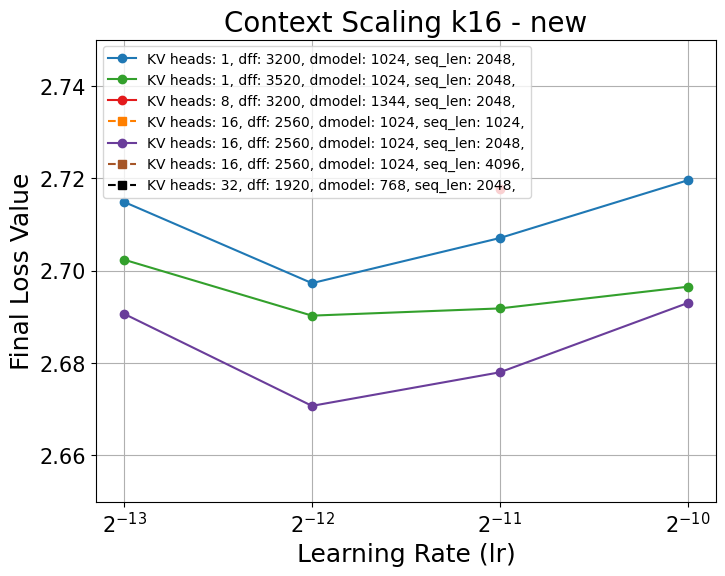

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
plot_loss_vs_lr(
    df,
    (2.65, 2.75),
    figsize=(6, 6),
    title="Context Scaling k16 - new",
    ax=axes,
    main_varibles=['job_config/common/kv_heads', 'job_config/common/dff', 'job_config/common/dmodel', 'job_config/common/sequence_length'],
    ax_labels_font=18,
    tick_font=15,
    title_font=20,
    print_etas=True)

In [6]:
print(df[["job_config/common/dff", "job_config/common/kv_heads", "job/full_save_checkpoints_path"]])
grid_params = ["job_config/common/dff", "job_config/common/kv_heads"]

    job_config/common/dff  job_config/common/kv_heads  \
0                    3840                          16   
1                    3840                          16   
2                    1920                          16   
3                    3840                          16   
4                    1920                          16   
5                    1920                          16   
6                    2560                          16   
7                    2560                          16   
8                    2560                          16   
9                    2560                          16   
10                   3200                           8   
11                   1920                          32   
12                   2560                          16   
13                   2560                          16   
14                   2560                          16   
15                   2560                          16   
16                   3520      

In [7]:
import re

for _, row in df.iterrows():
    yaml_overrides = []
    for p in grid_params:
        key = re.sub(r"^job_config/", "", p).replace("/", ".")  # <- transform COLUMN NAME
        yaml_overrides.append(f"{key}={row[p]}")

    ckpt_path = row["job/full_save_checkpoints_path"]

    print(f"yaml_overrides: {yaml_overrides}")
    print(f"ckpt_path: {ckpt_path}")
    print([c for c in df.columns if "yaml" in c.lower()])


    run_id = row['sys/id']  # Assuming 'sys/id' is the run identifier
    print(f'run ID: {run_id}')
    project_name = "pmtest/llm-random"
    # run_id = "LLMRANDOM-2078"
    run = neptune.init_run(
        project=project_name,
        with_id=run_id,
        mode="read-only",
        api_token=os.environ["NEPTUNE_API_TOKEN"],
    )
    run["yaml_config"].download(destination=f"tmp.yaml")

yaml_overrides: ['common.dff=3840', 'common.kv_heads=16']
ckpt_path: /lustre/pd01/plgrid/plgllmefficont2/nano/context_scaling/models/4490480/2
[]
run ID: LLMRANDOM-41905
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41905
yaml_overrides: ['common.dff=3840', 'common.kv_heads=16']
ckpt_path: /lustre/pd01/plgrid/plgllmefficont2/nano/context_scaling/models/4513297/1
[]
run ID: LLMRANDOM-41904
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41904
yaml_overrides: ['common.dff=1920', 'common.kv_heads=16']
ckpt_path: /lustre/pd01/plgrid/plgllmefficont2/nano/context_scaling/models/4490479/2
[]
run ID: LLMRANDOM-41903
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41903
yaml_overrides: ['common.dff=3840', 'common.kv_heads=16']
ckpt_path: /lustre/pd01/plgrid/plgllmefficont2/nano/context_scaling/models/451329

In [8]:
def make_csv_name(template: str, yaml_overrides: list[str]) -> str:
    """Build CSV filename from template keywords and yaml_overrides values.

    Example: template="kv_h,dff", overrides=["common.kv_heads=4", "common.dff=512"]
    Returns: "kv_h=4-dff=512.csv"
    """
    overrides_dict = {}
    for ov in yaml_overrides:
        key, val = ov.split("=", 1)
        overrides_dict[key.split(".")[-1]] = val  # use last part of key

    parts = []
    for kw in template.split(","):
        kw = kw.strip()
        matches = [k for k in overrides_dict if kw in k]
        if not matches:
            raise ValueError(f"Keyword '{kw}' not found in yaml_overrides: {yaml_overrides}")
        parts.append(f"{kw}={overrides_dict[matches[0]]}")

    return "+".join(parts) + ".csv"

In [9]:
tmplt = "kv_h,dff"
csv_names = make_csv_name(tmplt, yaml_overrides)
print(csv_names)

kv_h=16+dff=2560.csv


In [10]:
python -m src.context_scaling.scripts.eval_models \
    --tags context_scaling 42B \
    --dataset_dir /storage_nvme_1/llm-random/datasets/c4/long_context_2048n8192 \
    --out_csv_format "kv_heads,dff" \
    --out_dir mhavsmqa42Bk16 \
    --seq_len 2048 \
    --batch_size 32 \
    --model_step 320000 \
    --tmp_ckpt_path "/storage_nvme_4/nano/models/from_helios/rsync_from_python"

SyntaxError: invalid decimal literal (2268491562.py, line 2)

In [ ]:
scp j321m@entropy:/home/j321m/nano/MHA_fwe.csv .
